In [72]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from scipy import signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
'''
rates and angles come in as a list of arrays, with each array of angles being one the 7 anaotomical angles ['ankle', 'knee', 'hip', 'limbfoot', 'elbow', 'shoulder', 'forelimb']

1. peaks are identified and the angle is converted to phase
    phase is converted to a sine and cosine wave

the winer filter is trained to take reformatted neural data and turn it into a prediction of sine and cosine

2. predicted sine and cosine are used to find the angle of phase via arctan2
'''
def phase_train(rates, angles):
    full_rates, full_angles = session512.stitch_and_format(rates, angles)
    peak_list0 = tailored_peaks(full_angles, 0)
    peak_list1 = tailored_peaks(full_angles, 1)
    peak_list2 = tailored_peaks(full_angles, 2)
    peak_list3 = tailored_peaks(full_angles, 3)
    peak_list4 = tailored_peaks(full_angles, 4)
    peak_list5 = tailored_peaks(full_angles, 5)
    peak_list6 = tailored_peaks(full_angles, 6)
    phase_list0 = to_phasex(peak_list0, full_angles[:,0])
    phase_list1 = to_phasex(peak_list1, full_angles[:,1])
    phase_list2 = to_phasex(peak_list2, full_angles[:,2])
    phase_list3 = to_phasex(peak_list3, full_angles[:,3])
    phase_list4 = to_phasex(peak_list4, full_angles[:,4])
    phase_list5 = to_phasex(peak_list5, full_angles[:,5])
    phase_list6 = to_phasex(peak_list6, full_angles[:,6])
    phase_list = np.vstack((phase_list0,phase_list1,phase_list2,phase_list3,phase_list4,phase_list5,phase_list6)).T
    print(phase_list.shape)
    sin_array, cos_array = sine_and_cosine(phase_list)
    print(sin_array.shape)
    h, _, _, _ = decode_kfolds(X=full_rates, Y=full_angles)
    h_sin, _, _, _ = decode_kfolds(X=full_rates, Y=sin_array)
    h_cos, _, _, _ = decode_kfolds(X=full_rates, Y=cos_array)
    predicted_angle = predicted_lines(full_rates, h)
    predicted_sin = predicted_lines(full_rates, h_sin)
    predicted_cos = predicted_lines(full_rates, h_cos)
    arctans = arctan_fn(predicted_sin, predicted_cos)
    return arctans, phase_list
    
def arctan_fn(predicted_sin, predicted_cos):   
    arctans = []
    for i in range(predicted_sin.shape[1]):
        arctan_angles = (np.arctan2(predicted_sin[:,i],predicted_cos[:,i]) * 180 / np.pi) +180
        arctans.append(arctan_angles)
    arctans = np.array(arctans).T    
    return arctans

    
def predicted_lines(actual, H):
    holding_array = []
    for ii in range(H.shape[1]):
        temp1 = test_wiener_filter(actual, H[:,ii])
        holding_array.append(temp1)
    holding_array = np.array(holding_array).T
    return holding_array
    
def sine_and_cosine(phase_list):
    sin_array = []
    cos_array = []
    for i in range(phase_list.shape[1]):
        sin = (np.sin(phase_list[:,i]*np.pi/180))
        cos = (np.cos(phase_list[:,i]*np.pi/180))
        sin_array.append(sin)
        cos_array.append(cos)
    sin_array = np.array(sin_array).T
    cos_array = np.array(cos_array).T
    return sin_array, cos_array

def to_phasex(peaks, angles):
    for i in range(0,peaks.shape[0]-1):
        for j in range(0, peaks[i+1]-peaks[i]):
            angles[peaks[i]+j] = j*360/(peaks[i+1]-peaks[i])
        angles[-1] = 0
    return angles

                
def tailored_peaks(angles, index):
    peak_dict = {
            0 : {
                'signal': -(angles[:,index]),
                'prominence': 5,
                'distance': 5,
                'width' : 2,
                'height' : -1.2*np.mean(angles[:,index])
            },
            1 : {
                'signal': angles[:,index],
                'prominence': 10,
                'distance': None,
                'width' : None,
                'height' : np.mean(angles[:,index])
            },
            2 : {
                'signal': angles[:,index],
                'prominence': 5,
                'distance': None,
                'width' : 2,
                'height' : np.mean(angles[:,index])
            },
            3 : {
                'signal': angles[:,index],
                'prominence': 10,
                'distance': None,
                'width' : None,
                'height' : np.mean(angles[:,index])
            },
            4 : {
                'signal': angles[:,index],
                'prominence': 6.5,
                'distance': 5,
                'width' : None,
                'height' : 1.1*np.mean(angles[:,index])
            },
            5 : {
                'signal': -(angles[:,index]),
                'prominence': 5,
                'distance': None,
                'width' : None,
                'height' : -1.1*np.mean(angles[:,index])
            },
            6 : {
                'signal': angles[:,index],
                'prominence': 9,
                'distance': 5,
                'width' : None,
                'height' : None
            }
        }
    peaks, _ = spicy.signal.find_peaks(peak_dict[index]['signal'], prominence=peak_dict[index]['prominence'], distance =peak_dict[index]['distance'], width =peak_dict[index]['width'], height =peak_dict[index]['height'])    
    peaks = np.concatenate([[0],peaks,[np.shape(angles[:,index])[0]-1]])
    return peaks



In [66]:
    
def wave_align(waves):#, plot_req):
    temp_shift = []
    ts = np.linspace(0, (waves.shape[0]*50)/1000,waves.shape[0])
    dx = np.mean(np.diff(ts))
    for target in [waves[:,0], waves[:,1], waves[:,2]]:
        shift = (np.argmax(signal.correlate(waves[:,3], target)) - len(target)) * dx
        temp_shift = np.append(temp_shift, shift)
    temp_shift = np.append(temp_shift, 0)
    for target in [waves[:,4], waves[:,5]]:
        shift = (np.argmax(signal.correlate(waves[:,6], target)) - len(target)) * dx
        temp_shift = np.append(temp_shift, shift)
    temp_shift = np.append(temp_shift, 0)
    # temp_shift = np.array(temp_shift)
    return temp_shift

In [74]:
def alignment_check(tsf, arctans, full_phase):
    dx = np.mean(np.diff(tsf))
    temp_shift = []
    target = [arctans[:,0], arctans[:,1], arctans[:,2], arctans[:,3], arctans[:,4], arctans[:,5], arctans[:,6]]
    for i in range(len(target)):
        shift = (np.argmax(signal.correlate(full_phase[:,i], target[i])) - len(target[i])) * dx
        temp_shift.append(shift)
    return temp_shift

In [75]:
with open('/mnt/c/oobootoo/rat-fes/data/pickles/rat-annie_5-12_session.pkl', 'rb') as inp:
    session512 = pickle.load(inp)
rates512 = session512.data['rates']
angles512 = session512.data['angles']
coords512 = session512.data['coords']

In [76]:
arctans, phase_list = phase_train(rates512, angles512)
tsf = np.linspace(0, (phase_list.shape[0]*50)/1000,phase_list.shape[0])

(14210, 7)
(14210, 7)


In [77]:
print(alignment_check(tsf, arctans, phase_list))

[-0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
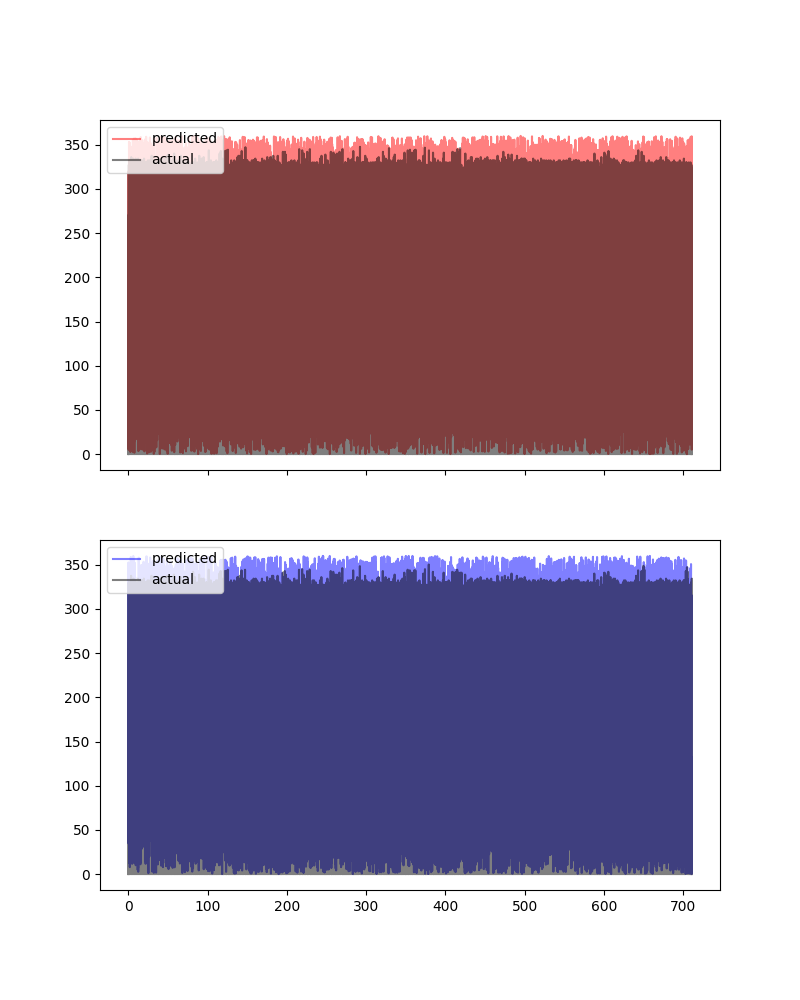

In [78]:
fig512, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
# ax[0].set_title('knee_phase = ' + str(vaf(full_phase512[:,1],arctans512[:,1])))
ax[0].plot(tsf, arctans[:,1], c='r', alpha=0.5, label = "predicted")
ax[0].plot(tsf, phase_list[:,1], c='k', alpha=0.5, label = "actual")
ax[0].legend(loc="upper left")
# ax[1].set_title('limbfoot_phase = ' + str(vaf(full_phase512[:,3],arctans512[:,3])))
ax[1].plot(tsf, arctans[:,3], c='blue', alpha=0.5, label = "predicted")
ax[1].plot(tsf, phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax[1].legend(loc="upper left")